# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [38]:
import numpy as np
from collections import Counter
import operator

In [39]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [46]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [47]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [48]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [49]:
token2id, id2token,  _  = index.get_dictionary()
#print(type(id2token.items()),'\n')
print(list(id2token.items())[:15],'\n')

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')] 



Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [50]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [51]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [52]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens), matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.50% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [56]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(type(f_topics))
    print(parse_topics([f_topics]))

<class '_io.TextIOWrapper'>
OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poa

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

For choosing the best parameters, we have the following criteria. NDCG@10, MAP@1000, precision@5,recall@1000.

So we use validation set to get these tuning data:


$\textbf{DP_parameter(500,750,1000,1250,1500)}$

NDCG             0.4758 0.4736 0.4674 0.4666 0.4672

MAP              0.4170 0.4168 0.4154 0.4149 0.4147

precision        0.4467 0.4467 0.4533 0.4467 0.4533

recall           0.9932 0.9932 0.9932 0.9932 0.9932


$\textbf{For DP the best parameter is}$ $\mu = 500$

$\textbf{JM_parameter(0.1,0.3,0.5,0.7,0.9)}$

NDCG             0.4766 0.4725 0.4654 0.4622 0.4571

MAP              0.4124 0.4123 0.4116 0.4105 0.4078

precision        0.4800 0.4600 0.4333 0.4533 0.4333

recall           0.9957 0.9957 0.9957 0.9957 0.9957


$\textbf{the JM model the best parameter is}$ $\lambda = 0.1$


$\textbf{AD_parameter(0.1,0.3,0.5,0.7,0.9)}$

NDCG             0.4499 0.4584 0.4464 0.4599 0.4596.

MAP              0.4003 0.4080 0.4082 0.4081 0.4047.

precision        0.4400 0.4600 0.4600 0.4600 0.4400.

recall           0.9957 0.9957 0.9954 0.9954 0.9954.


$\textbf{so AD model the best parameter is}$ $\delta = 0.7$

Result on the test set:

$\textbf{TF-IDF (test set)}$

NDCG            0.4169

MAP             0.2154

precision       0.4317

recall          0.6501


$\textbf{BM25(test results)}$

NDCG            0.4086  

MAP             0.2173

precision       0.4133

recall          0.6524

$\textbf{PLM (only top10 from tfidf)}$

$\textbf{circle_kernel}$

NDCG        0.3959

precision   0.3767

$\textbf{cosine_kernel}$

NDCG        0.3965

precision   0.3767

$\textbf{gaussian_kernel}$

NDCG        0.3972

precision   0.3767

$\textbf{passage_kernel}$

NDCG        0.3959

precision   0.3767

$\textbf{triangle_kernel}$

NDCG        0.3960

precision   0.3767


Here we have all the graphs for hyperparameters by using validation set:
ADim.png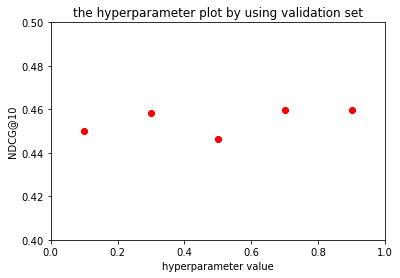

DPim.png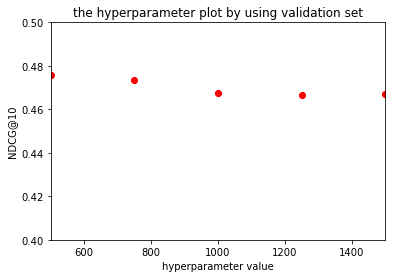

JMim.png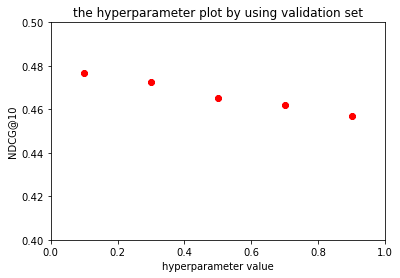

For the [test_data](https://drive.google.com/drive/folders/194pqQDzpv4bHKGTu9v4-nCaQqjnjvzMH?usp=sharing) 

Follow above link we can get all the test data for student t test

In [11]:
import time

start_time = time.time()

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0
ext_doc_id_to_doc_id = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    ext_doc_id_to_doc_id[ext_doc_id] = int_doc_id
    
    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 53.72804045677185 seconds.


In [12]:
# Collect validation set query_id and doc_id

f_qrel_validation = open('ap_88_89/qrel_validation', 'r')
validation_query_document = {}
for line in f_qrel_validation:    
    query_id = line.split(' ')[0]
    ext_doc_id = line.split(' ')[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = ext_doc_id_to_doc_id[ext_doc_id]
    if query_id in validation_query_document:        
        validation_query_document[query_id][doc_id]= 1
    else:
        validation_query_document[query_id] = {doc_id: 1}

In [274]:
import operator
from collections import Counter

def run_retrieval(model_name, score_fn, parameter = None, kernels = None, get_best_parameter = True):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)
    
    # TODO
    #if os.path.exists(run_out_path):
    #    return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}
    
    if model_name == 'tfidf':
        # for print progress
        count_progress = 0
        
        # loop of query ids to get score for query and doc pair
        for query_id, query_term_ids in tokenized_queries.items():  
            
            count_progress += 1
            print('Progess: ' + "{0:.2f}".format(count_progress / len(tokenized_queries) * 100) + '%', end='\r', flush=True)                        
            
            # score_dict for one query to multiple documents
            score_dict = {}
            
            # for generating data output
            query_tuple = ()
            
            # loop of doc ids and query_term_ids            
            for query_term_id in query_term_ids:
                for int_doc_id in inverted_index[query_term_id]:

                    document_term_frequency = 0
                    if query_term_id not in inverted_index:
                        pass
                    elif int_doc_id not in inverted_index[query_term_id]:
                        pass
                    else:
                        document_term_frequency = inverted_index[query_term_id][int_doc_id]
                    # score function to get score
                    score = score_fn(int_doc_id, query_term_id, document_term_frequency)
                    
                    if int_doc_id in score_dict:
                        score_dict[int_doc_id] += score
                    else:
                        score_dict[int_doc_id] = score            
                        
            sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]
            
            # for fitting output format
            for int_doc_id, score in sorted_score_list:                
                query_tuple += ((score, index.document(int_doc_id)[0]), )
            
            if len(query_tuple) > 0:
                data[str(query_id)] = query_tuple                            
        print()  
        
    elif model_name == 'BM25':
        # for print progress
        count_progress = 0
        
        # loop of query ids to get score for query and doc pair
        for query_id, query_term_ids in tokenized_queries.items():  
            
            count_progress += 1
            print('Progess: ' + "{0:.2f}".format(count_progress / len(tokenized_queries) * 100) + '%', end='\r', flush=True)                        
            
            # score_dict for one query to multiple documents
            score_dict = {}
            
            # for generating data output
            query_tuple = ()
                        
            # loop of doc ids and query_term_ids
            for query_term_id in query_term_ids:
                for int_doc_id in inverted_index[query_term_id]:
                    
                    document_term_frequency = 0
                    if query_term_id not in inverted_index:
                        pass
                    elif int_doc_id not in inverted_index[query_term_id]:
                        pass
                    else:
                        document_term_frequency = inverted_index[query_term_id][int_doc_id]
                    
                    # score function to get score
                    score = score_fn(int_doc_id, query_term_id, document_term_frequency, \
                                     document_lengths[int_doc_id], avg_doc_length)
                    if int_doc_id in score_dict:
                        score_dict[int_doc_id] += score
                    else:
                        score_dict[int_doc_id] = score
            
            
            sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]
            
            for int_doc_id, score in sorted_score_list:                
                query_tuple += ((score, index.document(int_doc_id)[0]), )
            
            if len(query_tuple) > 0:
                data[str(query_id)] = query_tuple                            
        print()               
        
    elif 'Jelinek_Mercer' in model_name:
        # for print progress
        count_progress = 0
        if get_best_parameter:
            # loop of query ids to get score for query and doc pair
            for query_id in validation_query_document:

                count_progress += 1
                print('Progess: ' + "{0:.2f}".format(count_progress / len(validation_query_document) * 100) + '%', end='\r', flush=True)

                # get query term id from query_id
                if query_id in tokenized_queries:
                    query_term_ids = tokenized_queries[query_id]
                else:
                    print('unseen query_id:', query_id)
                    continue

                # score_dict for one query to multiple documents
                score_dict = {}

                # for generating data output
                query_tuple = ()

                int_doc_ids = validation_query_document[query_id]
                # loop of doc ids and query_term_ids
                for query_term_id in query_term_ids:
                    for int_doc_id in int_doc_ids:

                        document_term_frequency = 0
                        if query_term_id not in inverted_index:
                            pass
                        elif int_doc_id not in inverted_index[query_term_id]:
                            pass
                        else:
                            document_term_frequency = inverted_index[query_term_id][int_doc_id]

                        # score function to get score
                        score = score_fn(int_doc_id, query_term_id, document_term_frequency, \
                                         document_lengths[int_doc_id], collection_frequencies[query_term_id], total_terms, parameter)
                        if int_doc_id in score_dict:
                            score_dict[int_doc_id] += score
                        else:
                            score_dict[int_doc_id] = score


                sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

                for int_doc_id, score in sorted_score_list:                
                    query_tuple += ((score, index.document(int_doc_id)[0]), )

                if len(query_tuple) > 0:
                    data[str(query_id)] = query_tuple                            
            print()
        else:
            # loop of query ids to get score for query and doc pair
            for query_id, query_term_ids in tokenized_queries.items():

                count_progress += 1
                print('Progess: ' + "{0:.2f}".format(count_progress / len(tokenized_queries) * 100) + '%', end='\r', flush=True)                

                # score_dict for one query to multiple documents
                score_dict = {}

                # for generating data output
                query_tuple = ()
                
                # loop of doc ids and query_term_ids
                for query_term_id in query_term_ids:
                    for int_doc_id in inverted_index[query_term_id]:

                        document_term_frequency = 0
                        if query_term_id not in inverted_index:
                            pass
                        elif int_doc_id not in inverted_index[query_term_id]:
                            pass
                        else:
                            document_term_frequency = inverted_index[query_term_id][int_doc_id]

                        # score function to get score
                        score = score_fn(int_doc_id, query_term_id, document_term_frequency, \
                                         document_lengths[int_doc_id], collection_frequencies[query_term_id], total_terms, parameter)
                        if int_doc_id in score_dict:
                            score_dict[int_doc_id] += score
                        else:
                            score_dict[int_doc_id] = score


                sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

                for int_doc_id, score in sorted_score_list:                
                    query_tuple += ((score, index.document(int_doc_id)[0]), )

                if len(query_tuple) > 0:
                    data[str(query_id)] = query_tuple                            
            print()
    elif 'Dirichlet_Prior' in model_name:
        # for print progress
        count_progress = 0
        if get_best_parameter:
            # loop of query ids to get score for query and doc pair
            for query_id in validation_query_document:

                count_progress += 1
                print('Progess: ' + "{0:.2f}".format(count_progress / len(validation_query_document) * 100) + '%', end='\r', flush=True)

                # get query term id from query_id
                if query_id in tokenized_queries:
                    query_term_ids = tokenized_queries[query_id]
                else:
                    print('unseen query_id:', query_id)
                    continue

                # score_dict for one query to multiple documents
                score_dict = {}

                # for generating data output
                query_tuple = ()

                int_doc_ids = validation_query_document[query_id]
                # loop of doc ids and query_term_ids
                for query_term_id in query_term_ids:
                    for int_doc_id in int_doc_ids:

                        document_term_frequency = 0
                        if query_term_id not in inverted_index:
                            pass
                        elif int_doc_id not in inverted_index[query_term_id]:
                            pass
                        else:
                            document_term_frequency = inverted_index[query_term_id][int_doc_id]

                        # score function to get score
                        score = score_fn(int_doc_id, query_term_id, document_term_frequency, \
                                         document_lengths[int_doc_id], collection_frequencies[query_term_id], total_terms, parameter)
                        if int_doc_id in score_dict:
                            score_dict[int_doc_id] += score
                        else:
                            score_dict[int_doc_id] = score


                sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

                for int_doc_id, score in sorted_score_list:                
                    query_tuple += ((score, index.document(int_doc_id)[0]), )

                if len(query_tuple) > 0:
                    data[str(query_id)] = query_tuple                            
            print() 
        else:
            # loop of query ids to get score for query and doc pair
            for query_id, query_term_ids in tokenized_queries.items():

                count_progress += 1
                print('Progess: ' + "{0:.2f}".format(count_progress / len(tokenized_queries) * 100) + '%', end='\r', flush=True)                

                # score_dict for one query to multiple documents
                score_dict = {}

                # for generating data output
                query_tuple = ()

                # loop of doc ids and query_term_ids
                for query_term_id in query_term_ids:
                    for int_doc_id in inverted_index[query_term_id]:

                        document_term_frequency = 0
                        if query_term_id not in inverted_index:
                            pass
                        elif int_doc_id not in inverted_index[query_term_id]:
                            pass
                        else:
                            document_term_frequency = inverted_index[query_term_id][int_doc_id]

                        # score function to get score
                        score = score_fn(int_doc_id, query_term_id, document_term_frequency, \
                                         document_lengths[int_doc_id], collection_frequencies[query_term_id], total_terms, parameter)
                        if int_doc_id in score_dict:
                            score_dict[int_doc_id] += score
                        else:
                            score_dict[int_doc_id] = score


                sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

                for int_doc_id, score in sorted_score_list:                
                    query_tuple += ((score, index.document(int_doc_id)[0]), )

                if len(query_tuple) > 0:
                    data[str(query_id)] = query_tuple                            
            print() 
    elif 'Absolute_discounting' in model_name:
        # for print progress
        count_progress = 0
        if get_best_parameter:
            # loop of query ids to get score for query and doc pair
            for query_id in validation_query_document:

                count_progress += 1
                print('Progess: ' + "{0:.2f}".format(count_progress / len(validation_query_document) * 100) + '%', end='\r', flush=True)

                # get query term id from query_id
                if query_id in tokenized_queries:
                    query_term_ids = tokenized_queries[query_id]
                else:
                    print('unseen query_id:', query_id)
                    continue

                # score_dict for one query to multiple documents
                score_dict = {}

                # for generating data output
                query_tuple = ()

                int_doc_ids = validation_query_document[query_id]
                # loop of doc ids and query_term_ids
                for query_term_id in query_term_ids:
                    for int_doc_id in int_doc_ids:    

                        document_term_frequency = 0
                        if query_term_id not in inverted_index:
                            pass
                        elif int_doc_id not in inverted_index[query_term_id]:
                            pass
                        else:
                            document_term_frequency = inverted_index[query_term_id][int_doc_id]

                        # score function to get score
                        score = score_fn(int_doc_id, query_term_id, document_term_frequency, \
                                         document_lengths[int_doc_id], collection_frequencies[query_term_id], unique_terms_per_document[int_doc_id], total_terms, parameter)
                        if int_doc_id in score_dict:
                            score_dict[int_doc_id] += score
                        else:
                            score_dict[int_doc_id] = score


                sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

                for int_doc_id, score in sorted_score_list:                
                    query_tuple += ((score, index.document(int_doc_id)[0]), )

                if len(query_tuple) > 0:
                    data[str(query_id)] = query_tuple                            
            print()
        else:
            # loop of query ids to get score for query and doc pair
            for query_id, query_term_ids in tokenized_queries.items():

                count_progress += 1
                print('Progess: ' + "{0:.2f}".format(count_progress / len(tokenized_queries) * 100) + '%', end='\r', flush=True)                

                # score_dict for one query to multiple documents
                score_dict = {}

                # for generating data output
                query_tuple = ()
                
                # loop of doc ids and query_term_ids
                for query_term_id in query_term_ids:
                    for int_doc_id in inverted_index[query_term_id]:

                        document_term_frequency = 0
                        if query_term_id not in inverted_index:
                            pass
                        elif int_doc_id not in inverted_index[query_term_id]:
                            pass
                        else:
                            document_term_frequency = inverted_index[query_term_id][int_doc_id]

                        # score function to get score
                        score = score_fn(int_doc_id, query_term_id, document_term_frequency, \
                                         document_lengths[int_doc_id], collection_frequencies[query_term_id], unique_terms_per_document[int_doc_id], total_terms, parameter)
                        if int_doc_id in score_dict:
                            score_dict[int_doc_id] += score
                        else:
                            score_dict[int_doc_id] = score


                sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

                for int_doc_id, score in sorted_score_list:                
                    query_tuple += ((score, index.document(int_doc_id)[0]), )

                if len(query_tuple) > 0:
                    data[str(query_id)] = query_tuple                            
            print()
    elif 'PLM' in model_name:
        
        # some code will repeat five times for fives kernels
        
        # for five kernels
        data_0 = {}
        data_1 = {}
        data_2 = {}
        data_3 = {}
        data_4 = {}
        
        # for print progress
        count_progress = 0
                
        mu = parameter['mu']                
        
        # loop of query ids to get score for query and doc pair
        for query_id in tfidf_score_q_d_top10:                        
            
            count_progress += 1
            print('Progess: ' + "{0:.2f}".format(count_progress / len(tfidf_score_q_d_top10) * 100) + '%', end='\r', flush=True)
            
            # get query term id from query_id
            if query_id in tokenized_queries:
                query_term_ids = tokenized_queries[query_id]                
            else:
                print('unseen query_id:', query_id)
                continue
            
            # score_dict for one query to multiple documents
            score_dict_0 = {}
            score_dict_1 = {}
            score_dict_2 = {}
            score_dict_3 = {}
            score_dict_4 = {}
            
            # for generating data output
            query_tuple_0 = ()
            query_tuple_1 = ()
            query_tuple_2 = ()
            query_tuple_3 = ()
            query_tuple_4 = ()
            
            int_doc_ids = tfidf_score_q_d_top10[query_id]
            checked_query_term_id = {}
            
            # loop of doc ids and query_term_ids
            for query_term_id in query_term_ids:                
                if query_term_id in checked_query_term_id:
                    continue
                else:
                    checked_query_term_id[query_term_id] = 1
                
                for int_doc_id in int_doc_ids:    
                    
                    document = index.document(int_doc_id)[1]
                    p_w_given_D_i_0 = {}
                    p_w_given_D_i_1 = {}
                    p_w_given_D_i_2 = {}
                    p_w_given_D_i_3 = {}
                    p_w_given_D_i_4 = {}
                    
                    checked_words = {}
                    all_words_term_frequency_0 = {}
                    all_words_term_frequency_1 = {}
                    all_words_term_frequency_2 = {}
                    all_words_term_frequency_3 = {}
                    all_words_term_frequency_4 = {}
                    
                    for current_word in document:
                        
                        if current_word in checked_words:
                            continue
                        else:
                            checked_words[current_word] = 1 
                            
                        # calculate score for each position
                        for position_j in range(document_lengths[int_doc_id]):
                            
                            sum_distance_term_frequency_0 = 0
                            sum_distance_term_frequency_1 = 0
                            sum_distance_term_frequency_2 = 0
                            sum_distance_term_frequency_3 = 0
                            sum_distance_term_frequency_4 = 0
                            
                            for position_i in range(document_lengths[int_doc_id]):
                                if document[position_i] == current_word:
                                    sum_distance_term_frequency_0 += kernels[0](position_i, position_j)
                                    sum_distance_term_frequency_1 += kernels[1](position_i, position_j)
                                    sum_distance_term_frequency_2 += kernels[2](position_i, position_j)
                                    sum_distance_term_frequency_3 += kernels[3](position_i, position_j)
                                    sum_distance_term_frequency_4 += kernels[4](position_i, position_j)
                            
                            if current_word in p_w_given_D_i_0:
                                p_w_given_D_i_0[current_word][position_j] = sum_distance_term_frequency_0
                                p_w_given_D_i_1[current_word][position_j] = sum_distance_term_frequency_1
                                p_w_given_D_i_2[current_word][position_j] = sum_distance_term_frequency_2
                                p_w_given_D_i_3[current_word][position_j] = sum_distance_term_frequency_3
                                p_w_given_D_i_4[current_word][position_j] = sum_distance_term_frequency_4
                            else:
                                p_w_given_D_i_0[current_word] = {position_j: sum_distance_term_frequency_0}
                                p_w_given_D_i_1[current_word] = {position_j: sum_distance_term_frequency_1}
                                p_w_given_D_i_2[current_word] = {position_j: sum_distance_term_frequency_2}
                                p_w_given_D_i_3[current_word] = {position_j: sum_distance_term_frequency_3}
                                p_w_given_D_i_4[current_word] = {position_j: sum_distance_term_frequency_4}
                            
                            if position_j in all_words_term_frequency_0:
                                all_words_term_frequency_0[position_j] += sum_distance_term_frequency_0
                                all_words_term_frequency_1[position_j] += sum_distance_term_frequency_1
                                all_words_term_frequency_2[position_j] += sum_distance_term_frequency_2
                                all_words_term_frequency_3[position_j] += sum_distance_term_frequency_3
                                all_words_term_frequency_4[position_j] += sum_distance_term_frequency_4
                            else:
                                all_words_term_frequency_0[position_j] = sum_distance_term_frequency_0
                                all_words_term_frequency_1[position_j] = sum_distance_term_frequency_1
                                all_words_term_frequency_2[position_j] = sum_distance_term_frequency_2
                                all_words_term_frequency_3[position_j] = sum_distance_term_frequency_3
                                all_words_term_frequency_4[position_j] = sum_distance_term_frequency_4
                    
                    count_query_ids = Counter(query_term_ids)
                    for current_word in p_w_given_D_i_0:
                        for position_j in p_w_given_D_i_0[current_word]:
                            p_w_given_D_i_0[current_word][position_j] += mu * collection_frequencies[query_term_id] / total_terms
                            p_w_given_D_i_0[current_word][position_j] /= (all_words_term_frequency_0[position_j] + mu)                                                        
                            
                            p_w_given_Q = count_query_ids[query_term_id] / len(query_term_ids)
                            
                            # score function to get score
                            score = score_fn(int_doc_id, query_term_id, p_w_given_Q, p_w_given_D_i_0[current_word][position_j])
                            if int_doc_id in score_dict_0:
                                if position_j in score_dict_0[int_doc_id]:
                                    score_dict_0[int_doc_id][position_j] += score                                    
                                else:
                                    score_dict_0[int_doc_id][position_j] = score                                    
                            else:
                                score_dict_0[int_doc_id] = {position_j: score}  
                                
                    for current_word in p_w_given_D_i_1:
                        for position_j in p_w_given_D_i_1[current_word]:
                            p_w_given_D_i_1[current_word][position_j] += mu * collection_frequencies[query_term_id] / total_terms
                            p_w_given_D_i_1[current_word][position_j] /= (all_words_term_frequency_1[position_j] + mu)                                                        
                                                            
                            p_w_given_Q = count_query_ids[query_term_id] / len(query_term_ids)
                            
                            # score function to get score
                            score = score_fn(int_doc_id, query_term_id, p_w_given_Q, p_w_given_D_i_1[current_word][position_j])
                            if int_doc_id in score_dict_1:
                                if position_j in score_dict_1[int_doc_id]:
                                    score_dict_1[int_doc_id][position_j] += score                                    
                                else:
                                    score_dict_1[int_doc_id][position_j] = score                                    
                            else:
                                score_dict_1[int_doc_id] = {position_j: score} 
                                
                    for current_word in p_w_given_D_i_2:
                        for position_j in p_w_given_D_i_2[current_word]:
                            p_w_given_D_i_2[current_word][position_j] += mu * collection_frequencies[query_term_id] / total_terms
                            p_w_given_D_i_2[current_word][position_j] /= (all_words_term_frequency_2[position_j] + mu)                                                        
                                                            
                            p_w_given_Q = count_query_ids[query_term_id] / len(query_term_ids)
                            
                            # score function to get score
                            score = score_fn(int_doc_id, query_term_id, p_w_given_Q, p_w_given_D_i_2[current_word][position_j])
                            if int_doc_id in score_dict_2:
                                if position_j in score_dict_2[int_doc_id]:
                                    score_dict_2[int_doc_id][position_j] += score                                    
                                else:
                                    score_dict_2[int_doc_id][position_j] = score                                    
                            else:
                                score_dict_2[int_doc_id] = {position_j: score} 
            
                    for current_word in p_w_given_D_i_3:
                        for position_j in p_w_given_D_i_3[current_word]:
                            p_w_given_D_i_3[current_word][position_j] += mu * collection_frequencies[query_term_id] / total_terms
                            p_w_given_D_i_3[current_word][position_j] /= (all_words_term_frequency_3[position_j] + mu)                                                        
                                                            
                            p_w_given_Q = count_query_ids[query_term_id] / len(query_term_ids)
                            
                            # score function to get score
                            score = score_fn(int_doc_id, query_term_id, p_w_given_Q, p_w_given_D_i_3[current_word][position_j])
                            if int_doc_id in score_dict_3:
                                if position_j in score_dict_3[int_doc_id]:
                                    score_dict_3[int_doc_id][position_j] += score                                    
                                else:
                                    score_dict_3[int_doc_id][position_j] = score                                    
                            else:
                                score_dict_3[int_doc_id] = {position_j: score} 
                                
                    for current_word in p_w_given_D_i_4:
                        for position_j in p_w_given_D_i_4[current_word]:
                            p_w_given_D_i_4[current_word][position_j] += mu * collection_frequencies[query_term_id] / total_terms
                            p_w_given_D_i_4[current_word][position_j] /= (all_words_term_frequency_4[position_j] + mu)                                                        
                                                            
                            p_w_given_Q = count_query_ids[query_term_id] / len(query_term_ids)
                            
                            # score function to get score
                            score = score_fn(int_doc_id, query_term_id, p_w_given_Q, p_w_given_D_i_4[current_word][position_j])
                            if int_doc_id in score_dict_4:
                                if position_j in score_dict_4[int_doc_id]:
                                    score_dict_4[int_doc_id][position_j] += score                                    
                                else:
                                    score_dict_4[int_doc_id][position_j] = score                                    
                            else:
                                score_dict_4[int_doc_id] = {position_j: score} 
                                
            for int_doc_id in score_dict_0:
                max_score = float('-inf')
                for position_j in score_dict_0[int_doc_id]:                
                    if score_dict_0[int_doc_id][position_j] > max_score:
                        max_score = score_dict_0[int_doc_id][position_j]
                score_dict_0[int_doc_id] = max_score
            
            sorted_score_list_0 = sorted(score_dict_0.items(), key=operator.itemgetter(1), reverse = True)[0:1000]
            
            for int_doc_id, score in sorted_score_list_0:
                query_tuple_0 += ((score, index.document(int_doc_id)[0]), )
            
            if len(query_tuple_0) > 0:
                data_0[str(query_id)] = query_tuple_0
                
            for int_doc_id in score_dict_1:
                max_score = float('-inf')
                for position_j in score_dict_1[int_doc_id]:                
                    if score_dict_1[int_doc_id][position_j] > max_score:
                        max_score = score_dict_1[int_doc_id][position_j]
                score_dict_1[int_doc_id] = max_score
            
            sorted_score_list_1 = sorted(score_dict_1.items(), key=operator.itemgetter(1), reverse = True)[0:1000]
            
            for int_doc_id, score in sorted_score_list_1:
                query_tuple_1 += ((score, index.document(int_doc_id)[0]), )
            
            if len(query_tuple_1) > 1:
                data_1[str(query_id)] = query_tuple_1
                
            for int_doc_id in score_dict_2:
                max_score = float('-inf')
                for position_j in score_dict_2[int_doc_id]:                
                    if score_dict_2[int_doc_id][position_j] > max_score:
                        max_score = score_dict_2[int_doc_id][position_j]
                score_dict_2[int_doc_id] = max_score
            
            sorted_score_list_2 = sorted(score_dict_2.items(), key=operator.itemgetter(1), reverse = True)[0:1000]
            
            for int_doc_id, score in sorted_score_list_2:
                query_tuple_2 += ((score, index.document(int_doc_id)[0]), )
            
            if len(query_tuple_2) > 2:
                data_2[str(query_id)] = query_tuple_2
                
            for int_doc_id in score_dict_3:
                max_score = float('-inf')
                for position_j in score_dict_3[int_doc_id]:                
                    if score_dict_3[int_doc_id][position_j] > max_score:
                        max_score = score_dict_3[int_doc_id][position_j]
                score_dict_3[int_doc_id] = max_score
            
            sorted_score_list_3 = sorted(score_dict_3.items(), key=operator.itemgetter(1), reverse = True)[0:1000]
            
            for int_doc_id, score in sorted_score_list_3:
                query_tuple_3 += ((score, index.document(int_doc_id)[0]), )
            
            if len(query_tuple_3) > 3:
                data_3[str(query_id)] = query_tuple_3
                
            for int_doc_id in score_dict_4:
                max_score = float('-inf')
                for position_j in score_dict_4[int_doc_id]:                
                    if score_dict_4[int_doc_id][position_j] > max_score:
                        max_score = score_dict_4[int_doc_id][position_j]
                score_dict_4[int_doc_id] = max_score
            
            sorted_score_list_4 = sorted(score_dict_4.items(), key=operator.itemgetter(1), reverse = True)[0:1000]
            
            for int_doc_id, score in sorted_score_list_4:
                query_tuple_4 += ((score, index.document(int_doc_id)[0]), )
            
            if len(query_tuple_4) > 4:
                data_4[str(query_id)] = query_tuple_4
            
        print() 
    
    if 'PLM' in model_name:
        count_kernel = 0
        for kernel in kernels:
            model_name_kernel = model_name + '_' + kernel.__name__
            if kernel.__name__ == 'gaussian_kernel':
                data = data_0
            elif kernel.__name__ == 'triangle_kernel':
                data = data_1
            elif kernel.__name__ == 'cosine_kernel':
                data = data_2
            elif kernel.__name__ == 'circle_kernel':
                data = data_3
            elif kernel.__name__ == 'passage_kernel':
                data = data_4
            else:
                raise              
                
            run_out_path = '{}.run'.format(model_name_kernel)
            
            with open(run_out_path, 'w') as f_out:
                write_run(
                    model_name=model_name_kernel,
                    data=data,
                    out_f=f_out,
                    max_objects_per_query=1000)
    else:                
        with open(run_out_path, 'w') as f_out:
            write_run(
                model_name=model_name,
                data=data,
                out_f=f_out,
                max_objects_per_query=1000)

In [57]:
# Get top 1000 for each query using TF-IDF in Task 1
f = open('task1/all_documents/tfidf.run', 'r')
tfidf_score_q_d = {}
for line in f:
    line_split = line.split(' ')
    query_id = str(line_split[0])
    ext_doc_id = line_split[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = int(ext_doc_id_to_doc_id[ext_doc_id])
    score = float(line_split[4])
    if query_id in tfidf_score_q_d:
        tfidf_score_q_d[query_id][doc_id] = score    
    else:
        tfidf_score_q_d[query_id] = {doc_id: score}
        
# Get top 1000 for each query using BM25 in Task 1
f = open('task1/all_documents/BM25.run', 'r')
bm25_score_q_d = {}
for line in f:
    line_split = line.split(' ')
    query_id = str(line_split[0])
    ext_doc_id = line_split[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = int(ext_doc_id_to_doc_id[ext_doc_id])
    score = float(line_split[4])
    if query_id in bm25_score_q_d:
        bm25_score_q_d[query_id][doc_id] = score    
    else:
        bm25_score_q_d[query_id] = {doc_id: score}        
        
f = open('task1/best_parameter/Absolute_discounting_best_0.9.run', 'r')
ad_score_q_d = {}
for line in f:
    line_split = line.split(' ')
    query_id = str(line_split[0])
    ext_doc_id = line_split[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = int(ext_doc_id_to_doc_id[ext_doc_id])
    score = float(line_split[4])
    if query_id in ad_score_q_d:
        ad_score_q_d[query_id][doc_id] = score    
    else:
        ad_score_q_d[query_id] = {doc_id: score}     
        
f = open('task1/best_parameter/Dirichlet_Prior_best_500.run', 'r')
dp_score_q_d = {}
for line in f:
    line_split = line.split(' ')
    query_id = str(line_split[0])
    ext_doc_id = line_split[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = int(ext_doc_id_to_doc_id[ext_doc_id])
    score = float(line_split[4])
    if query_id in dp_score_q_d:
        dp_score_q_d[query_id][doc_id] = score    
    else:
        dp_score_q_d[query_id] = {doc_id: score}      
        
f = open('task1/best_parameter/Jelinek_Mercer_best_0.1.run', 'r')
jm_score_q_d = {}
for line in f:
    line_split = line.split(' ')
    query_id = str(line_split[0])
    ext_doc_id = line_split[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = int(ext_doc_id_to_doc_id[ext_doc_id])
    score = float(line_split[4])
    if query_id in jm_score_q_d:
        jm_score_q_d[query_id][doc_id] = score    
    else:
        jm_score_q_d[query_id] = {doc_id: score}  
        
f = open('task3/word2vec.run', 'r')
word2vec_score_q_d = {}
for line in f:
    line_split = line.split(' ')
    query_id = str(line_split[0])
    ext_doc_id = line_split[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = int(ext_doc_id_to_doc_id[ext_doc_id])
    score = float(line_split[4])
    if query_id in word2vec_score_q_d:
        word2vec_score_q_d[query_id][doc_id] = score    
    else:
        word2vec_score_q_d[query_id] = {doc_id: score}

In [275]:
# Get top 10 for each query using TF-IDF in Task 1 for PLM
f = open('tfidf.run', 'r')
tfidf_score_q_d_top10 = {}
for line in f:
    line_split = line.split(' ')
    query_id = str(line_split[0])
    ext_doc_id = line_split[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = int(ext_doc_id_to_doc_id[ext_doc_id])
    score = float(line_split[4])
    if query_id in tfidf_score_q_d_top10:
        if len(tfidf_score_q_d_top10[query_id]) > 9:
            continue
        tfidf_score_q_d_top10[query_id][doc_id] = score    
    else:
        tfidf_score_q_d_top10[query_id] = {doc_id: score}

In [277]:
import numpy as np

def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
 
    score = 0    
    idf = np.log(num_documents / len(inverted_index[query_term_id]))
    score = np.log(1 + document_term_freq) * idf    
    
    return score

def BM25(int_document_id, query_term_id, document_term_freq, document_length, avg_doc_length, k_1 = 1.2, b = 0.75):
    

    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    :param document_length: total number of words of the document
    :param avg_doc_length: average document length
    :param k_1: parameter of BM25
    :param b: parameter of BM25
    """
    # TODO implement the function
    score = 0
    
    idf = np.log( num_documents / len(inverted_index[query_term_id]))
    score = (k_1 + 1) * document_term_freq * idf / \
            (k_1 * ((1 - b) + b * (document_length / avg_doc_length)) + document_term_freq)
        
    return score

def Jelinek_Mercer(int_document_id, query_term_id, document_term_freq, document_length, collection_term_freq, collection_length, lambda_value):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param document_length: total number of words of the document
    :param collection_term_freq: the collection term frequency of the query term
    :param collection_length: total number of words of the collection
    """
    
    score = 0
    
    p_lambda = lambda_value * document_term_freq / document_length + (1 - lambda_value) * collection_term_freq / collection_length
    score = np.log(p_lambda)
    
    return score

def Dirichlet_Prior(int_document_id, query_term_id, document_term_freq, document_length, collection_term_freq, total_term, mu):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    :param document_length: total number of words of the document
    :param collection_term_freq: the collection term frequency of the query term
    :param mu: parameter of Dirichlet Prior
    """
    
    score = 0
    
    alpha = mu * collection_term_freq + 1
    p_mu = document_length * document_term_freq / ((document_length + mu) * document_length) + \
           mu * (collection_term_freq / total_term) / (document_length + mu)
    
    score = np.log(p_mu)
    
    return score

def Absolute_discounting(int_document_id, query_term_id, document_term_freq, document_length, collection_term_freq, num_unique_terms_per_document, total_term, delta):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param document_length: total number of words of the document
    :param collection_term_freq: the collection term frequency of the query term
    """
    
    score = 0
        
    p_delta = max(document_term_freq - delta, 0) / document_length + delta * num_unique_terms_per_document * collection_term_freq / (document_length * total_term)
    
    score = np.log(p_delta)
    
    return score

def PLM(int_document_id, query_term_id, p_w_given_Q, p_w_given_D_i):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param p_w_given_Q: p(w|Q)
    :param p_w_given_D_i: p(w|D, i)
    """
    #print(p_w_given_Q * np.log(p_w_given_Q / p_w_given_D_i), p_w_given_Q, np.log(p_w_given_Q / p_w_given_D_i), p_w_given_D_i)
    return - p_w_given_Q * np.log(p_w_given_Q / p_w_given_D_i)

def gaussian_kernel(i, j, sigma = 50):
    return np.exp(-(i - j) ** 2 / (2 * sigma ** 2))

def triangle_kernel(i, j, sigma = 50):
    if abs(i - j) <= sigma:
        return 1 - abs(i - j) / sigma
    return 0

def cosine_kernel(i, j, sigma = 50):
    if abs(i - j) <= sigma:
        return 1/2 * (1 + np.cos(abs(i - j) * np.pi / sigma))
    return 0

def circle_kernel(i, j, sigma = 50):
    if abs(i - j) <= sigma:
        return np.sqrt(1 - (abs(i - j) / sigma) ** 2)
    return 0

def passage_kernel(i, j, sigma = 50):
    if abs(i - j) <= sigma:
        return 1
    return 0


# run tfidf
run_retrieval('tfidf', tfidf)

# run BM25
run_retrieval('BM25', BM25)

# run language models
best_parameter = False
if  best_parameter:
    lambda_Jelinek_Mercer = [0.1, 0.3, 0.5, 0.7, 0.9]
    for lambda_value in lambda_Jelinek_Mercer:    
        run_retrieval('Jelinek_Mercer_' + str(lambda_value), Jelinek_Mercer, lambda_value)

    mu_Dirichlet_Prior = [500, 750, 1000, 1250, 1500]
    for mu_value in mu_Dirichlet_Prior:    
        run_retrieval('Dirichlet_Prior_' + str(mu_value), Dirichlet_Prior, mu_value)

    delta_Absolute_discounting = [0.1, 0.3, 0.5, 0.7, 0.9]
    for delta_value in delta_Absolute_discounting:    
        run_retrieval('Absolute_discounting_' + str(delta_value), Absolute_discounting, delta_value)
else:
    best_lambda_value = 0.1
    best_mu_value = 500
    best_delta_value = 0.7
    run_retrieval('Jelinek_Mercer_best_' + str(best_lambda_value), Jelinek_Mercer, best_lambda_value, get_best_parameter = best_parameter)
    run_retrieval('Dirichlet_Prior_best_' + str(best_mu_value), Dirichlet_Prior, best_mu_value, get_best_parameter = best_parameter)
    run_retrieval('Absolute_discounting_best_' + str(best_delta_value), Absolute_discounting, best_delta_value, get_best_parameter = best_parameter)



# run PLM

best_mu_value = 500
run_retrieval('PLM', PLM, parameter = {'mu': best_mu_value}, kernels = [gaussian_kernel, triangle_kernel, cosine_kernel, circle_kernel, passage_kernel])
print()

Retrieving using PLM
Progess: 100.00%


### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

For significance tesing, we can also get the data from the above test data link

In [13]:
# transform corpus to corpus in tfidf format

import gensim

dictionary = pyndri.extract_dictionary(index)
class Tfidf_corpus(gensim.interfaces.CorpusABC):
    """Integrates an Index with Gensim's word2vec implementation."""

    def __init__(self, index, dictionary, max_documents=None):
        assert isinstance(index, pyndri.Index)

        self.index = index
        self.dictionary = dictionary        
        
        self.max_documents = max_documents

    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())                
            
    def __iter__(self):
        count = 0
        for int_doc_id in range(self.index.document_base(), self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)
                        
            counter_tokens = collections.Counter(
                token_id for token_id in tokens
                if token_id > 0)                        
                        
            document_list = []
            for word, count in counter_tokens.items():                
                document_list += [(word, count)]            
            
            yield document_list
        

    def __len__(self):
        return self._maximum_document() - self.index.document_base()

sentences = Tfidf_corpus(index, dictionary)
tfidf = gensim.models.tfidfmodel.TfidfModel(corpus = sentences)
corpus_tfidf = tfidf[sentences]

In [14]:
print('Number of words:', len(dictionary))
num_of_doc = index.maximum_document() - index.document_base()
print('Number of documents:', num_of_doc)
print('Upper bound of number of topics:', num_of_doc)
print('Lower bound of number of topics:', np.log(num_of_doc))
print('Estimate number of topics between upper bound and lower bound:', np.sqrt(num_of_doc))

Number of words: 267318
Number of documents: 164597
Upper bound of number of topics: 164597
Lower bound of number of topics: 12.01125534105658
Estimate number of topics between upper bound and lower bound: 405.7055582562309


In [15]:
# TFIDF to estimate number of topics
# We count unique word id from top 3 tfidf of each document
# Assumption: the similar topic should contain the similar words, so top-3 tfidf words of same topic should be similar.

counter_tfidf_top1 = Counter()
counter_tfidf_top3 = Counter()
count_progress = 0
for doc_tfidf in corpus_tfidf:
    count_progress += 1
    print('Progess: ' + "{0:.2f}".format(count_progress / len(corpus_tfidf) * 100) + '%', end='\r', flush=True)
    
    sorted_score_list_top1 = sorted(doc_tfidf, key=operator.itemgetter(1), reverse = True)[0:1]
    sorted_score_list_top3 = sorted(doc_tfidf, key=operator.itemgetter(1), reverse = True)[0:3]
    
    for word_id, score in sorted_score_list_top1:
        counter_tfidf_top1[word_id] += 1
    for word_id, score in sorted_score_list_top3:
        counter_tfidf_top3[word_id] += 1
    

In [16]:
# The numbers are far beyond our first estimate 405. Need to do more analysis.
# Second estimate: 40055
# Although both tfidf top1 and top3 is too large, 79657 is close to half of number of documents

print('Number of words of tfidf top1:', len(counter_tfidf_top1))
print('Number of words of tfidf top3:', len(counter_tfidf_top3))

Number of words of tfidf top1: 40055
Number of words of tfidf top3: 79657


In [17]:
# It seems that some words are not topic 
# Need a way to reduce estimate value of the number of topic

count = 0
for word_id in counter_tfidf_top1:
    count += 1
    if count > 30:
        break
    print(id2token[word_id])

keach
percent
bostetter
1
raja
million
000
crawfish
wtvt
crawford
crawfords
kean
keane
bush
soviet
united
wud
3
house
american
rajasthan
craxi
billion
cray
rajbansi
court
party
crayons
city
wednesday


There are 22900 topics(top1 tfidf) to be shown once.

Counter({1: 22900, 2: 6477, 3: 2867, 4: 1668, 5: 1091, 6: 788, 7: 594, 8: 435, 9: 350, 10: 281, 11: 229, 12: 215, 13: 192, 14: 145, 16: 126, 17: 111, 15: 106, 18: 99, 20: 86, 19: 81, 21: 71, 22: 54, 25: 54, 23: 49, 24: 49, 29: 39, 28: 36, 26: 35, 27: 35, 30: 33, 32: 33, 34: 31, 31: 25, 36: 24, 33: 23, 35: 22, 37: 22, 38: 20, 40: 20, 39: 17, 48: 17, 41: 16, 63: 16, 47: 15, 44: 14, 59: 14, 42: 12, 43: 12, 46: 12, 58: 12, 45: 11, 50: 11, 57: 11, 61: 11, 52: 10, 55: 9, 62: 9, 68: 9, 54: 7, 73: 7, 53: 6, 64: 6, 65: 6, 66: 6, 82: 6, 83: 6, 85: 6, 60: 6, 56: 5, 74: 5, 84: 5, 86: 5, 90: 5, 101: 5, 133: 5, 49: 4, 51: 4, 67: 4, 72: 4, 75: 4, 79: 4, 91: 4, 96: 4, 98: 4, 110: 4, 112: 4, 69: 3, 76: 3, 77: 3, 80: 3, 88: 3, 93: 3, 97: 3, 99: 3, 100: 3, 103: 3, 105: 3, 107: 3, 119: 3, 123: 3, 125: 3, 135: 3, 141: 3, 176: 3, 205: 3, 269: 3, 70: 2, 71: 2, 78: 2, 89: 2, 92: 2, 94: 2, 95: 2, 102: 2, 106: 2, 109: 2, 117: 2, 118: 2, 124: 2, 126: 2, 127: 

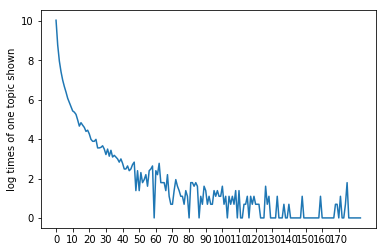

In [20]:
# Assumption: There are enough specific number of documents which belong to the same topic. We need to find out 
#             what's the specific number. 

import matplotlib.pyplot as plt

count = 0

counter_count_word = Counter()

for word_id in counter_tfidf_top1:       
    
    # count times of one topic to be shown(shown frequency), if two topics have the same shown frequency
    # we add 1
    counter_count_word[counter_tfidf_top1[word_id]] += 1

print('There are 22900 topics(top1 tfidf) to be shown once.\n')
print(counter_count_word)
    
y = []

for count_count_word in counter_count_word:   
    # count topic shown frequency
    y += [counter_count_word[count_count_word]]
    

plt.ylabel('log times of one topic shown')
plt.plot(np.log(y))
plt.xticks(np.arange(0.0, 175.0, 10.0))
plt.show()


In [23]:
# There should be a boundary between topic and "not a topic".
# According to graph, 50 might be a good choice. But considering computation resource we pick shown frequency >= 120 to do our training.
# Third estimate: 
counter_tfidf_top1_gt_120 = Counter(x for x in counter_tfidf_top1.elements() if counter_tfidf_top1[x] >= 120)
print('Third estimate of topic number:', len(counter_tfidf_top1_gt_120))

Third estimate of topic number: 96


In [24]:
NUM_TOPICS = 96
# create lsi model
lsi = gensim.models.lsimodel.LsiModel(corpus=corpus_tfidf, id2word= dictionary.id2token, num_topics=NUM_TOPICS)

In [25]:
# create lda model
lda = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word= dictionary.id2token, num_topics=NUM_TOPICS)

/home/jaqq/anaconda3/envs/ir/lib/python3.5/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [27]:
print(lsi.print_topics(NUM_TOPICS))

[(0, '-0.147*"percent" + -0.112*"bush" + -0.107*"stock" + -0.095*"1" + -0.093*"million" + -0.093*"market" + -0.087*"billion" + -0.087*"soviet" + -0.079*"dukakis" + -0.077*"prices"'), (1, '-0.233*"stock" + -0.182*"index" + -0.175*"market" + -0.156*"cents" + -0.147*"yen" + -0.143*"dollar" + -0.140*"prices" + -0.136*"trading" + -0.133*"exchange" + -0.130*"stocks"'), (2, '0.456*"cents" + 0.382*"cent" + 0.280*"futures" + 0.238*"bushel" + 0.183*"lower" + -0.177*"stock" + 0.165*"higher" + 0.153*"soybean" + 0.153*"wheat" + 0.152*"corn"'), (3, '0.440*"dukakis" + 0.312*"bush" + 0.169*"jackson" + 0.132*"campaign" + -0.123*"police" + -0.122*"israeli" + 0.114*"percent" + 0.107*"democratic" + -0.104*"israel" + -0.101*"soviet"'), (4, '0.372*"yen" + 0.311*"dollar" + 0.214*"dukakis" + -0.203*"percent" + 0.179*"bush" + 0.169*"tokyo" + -0.125*"billion" + 0.123*"gold" + 0.116*"soviet" + -0.111*"million"'), (5, '-0.306*"yen" + -0.287*"dollar" + 0.174*"stock" + 0.168*"index" + 0.167*"soviet" + -0.141*"gold"

In [28]:
print(lda.print_topics(NUM_TOPICS))

[(0, '0.019*"wedtech" + 0.014*"hirohito" + 0.014*"manglapus" + 0.013*"emperor" + 0.009*"biaggi" + 0.009*"apology" + 0.007*"cereal" + 0.007*"hirohitos" + 0.006*"packard" + 0.006*"intestinal"'), (1, '0.022*"stock" + 0.015*"index" + 0.014*"market" + 0.012*"stocks" + 0.011*"points" + 0.010*"exchange" + 0.009*"shares" + 0.009*"average" + 0.009*"dow" + 0.009*"0"'), (2, '0.022*"nuclear" + 0.019*"plant" + 0.010*"reactor" + 0.008*"explosions" + 0.008*"hodel" + 0.008*"uaw" + 0.007*"plants" + 0.007*"test" + 0.007*"radioactive" + 0.007*"energy"'), (3, '0.036*"israeli" + 0.033*"israel" + 0.027*"palestinian" + 0.025*"plo" + 0.022*"palestinians" + 0.020*"arab" + 0.017*"arafat" + 0.016*"gaza" + 0.015*"occupied" + 0.013*"shamir"'), (4, '0.035*"iran" + 0.030*"iranian" + 0.025*"hostages" + 0.022*"iraq" + 0.015*"lebanon" + 0.013*"hostage" + 0.013*"irans" + 0.011*"tehran" + 0.009*"islamic" + 0.009*"gulf"'), (5, '0.018*"hughes" + 0.014*"rigs" + 0.011*"rig" + 0.011*"furlough" + 0.009*"jordanian" + 0.008*"uni

In [53]:
# Calculate score for query and document pair and create output for lda model
# Rerank top 1000 of tfidf

model_name = 'lsi'
run_out_path = '{}.run'.format(model_name)
data = {}

corpus = []
count_progress = 0
for query_id in tfidf_score_q_d:        
    score_dict = {}
    count_progress += 1
    print('Progess: ' + "{0:.2f}".format(count_progress / len(tfidf_score_q_d) * 100) + '%', end='\r', flush=True)

    if query_id in tokenized_queries:
        query_term_ids = tokenized_queries[query_id]
    else:
        print('unseen query_id:', query_id)
        continue    

    query_corpus = []
    tokens = [x for x in query_term_ids if x > 0]
    counter_tokens = Counter(tokens)      
    for word, count in counter_tokens.items():
        query_corpus += [(word, count)]            

    int_doc_ids = tfidf_score_q_d[query_id]

    for int_doc_id in int_doc_ids:                               
        ext_doc_id, tokens = index.document(int_doc_id)
        tokens = [x for x in tokens if x > 0]
        counter_tokens = Counter(tokens)
        document_corpus = []    
        for word, count in counter_tokens.items():
            document_corpus += [(word, count)]
        
        document_corpus_lsi_vec = []
        query_corpus_lsi_vec = []
                
        score = gensim.matutils.cossim(lsi[document_corpus], lsi[query_corpus])
                
        score_dict[int_doc_id] = score
        
        
    query_tuple = ()        
    sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

    for int_doc_id, score in sorted_score_list:
        query_tuple += ((score, index.document(int_doc_id)[0]), )

    if len(query_tuple) > 0:
        data[str(query_id)] = query_tuple

with open(run_out_path, 'w') as f_out:
    write_run(
        model_name=model_name,
        data=data,
        out_f=f_out,
        max_objects_per_query=1000)

In [54]:
# Calculate score for query and document pair and create output for lda model
# Rerank top 1000 of tfidf

model_name = 'lda'
run_out_path = '{}.run'.format(model_name)
data = {}

corpus = []
count_progress = 0
for query_id in tfidf_score_q_d:        
    score_dict = {}
    count_progress += 1
    print('Progess: ' + "{0:.2f}".format(count_progress / len(tfidf_score_q_d) * 100) + '%', end='\r', flush=True)

    if query_id in tokenized_queries:
        query_term_ids = tokenized_queries[query_id]
    else:
        print('unseen query_id:', query_id)
        continue    

    query_corpus = []
    tokens = [x for x in query_term_ids if x > 0]
    counter_tokens = Counter(tokens)      
    for word, count in counter_tokens.items():
        query_corpus += [(word, count)]            

    int_doc_ids = tfidf_score_q_d[query_id]

    for int_doc_id in int_doc_ids:                               
        ext_doc_id, tokens = index.document(int_doc_id)
        tokens = [x for x in tokens if x > 0]
        counter_tokens = Counter(tokens)
        document_corpus = []    
        for word, count in counter_tokens.items():
            document_corpus += [(word, count)]        
        
        score = gensim.matutils.cossim(lda[document_corpus], lda[query_corpus])                      
        score_dict[int_doc_id] = score


    query_tuple = ()        
    sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

    for int_doc_id, score in sorted_score_list:
        query_tuple += ((score, index.document(int_doc_id)[0]), )

    if len(query_tuple) > 0:
        data[str(query_id)] = query_tuple

with open(run_out_path, 'w') as f_out:
    write_run(
        model_name=model_name,
        data=data,
        out_f=f_out,
        max_objects_per_query=1000)

For tuning the parameters, we have the following results:

$\textbf{LSI_number_of_topics(24,60,96)}$

NDCG        0.1500 0.2074 0.1899

MAP         0.1084 0.1368 0.1390

precision   0.1467 0.2267 0.1733

recall      0.6686 0.6686 0.6686


$\textbf{LDA_number_of_topics(24,60,96)}$

NDCG        0.0256 0.0405 0.1209

MAP         0.0588 0.0543 0.1201  

precision   0.0333 0.0400 0.1067

recall      0.6686 0.6686 0.6686


$\textbf{According to NDCG criterion, the best "number of topics" of LSI model is 60, but for LDA model it's 96.}$

Performance on test set

$\textbf{LSI (test set)}$

NDCG 0.1973

MAP  0.1066

precision 0.1967

recall    0.6501


$\textbf{LDA (test set)}$

NDCG 0.0834

MAP  0.0712

precision 0.0833

recall    0.6501







### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [55]:
# Create word2vec model and train
import pyndri.compat

EMBEDDING_SIZE = 300
NUM_ITER = 5
MIN_WORD_FREQUENCY = 10

word2vec = gensim.models.Word2Vec(
    size=EMBEDDING_SIZE,  # Embedding size
    window=5,  # One-sided window size
    sg=True,  # Skip-gram.
    min_count=MIN_WORD_FREQUENCY,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=1,  # Number of negative examples.
    iter=NUM_ITER,  # Number of iterations.
    workers=4,  # Number of workers.
)

dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

# Build vocab.
word2vec.build_vocab(sentences, trim_rule=None)
word2vec.train(sentences, total_examples=word2vec.corpus_count, epochs=word2vec.iter)

207781783

In [56]:
# Calculate score for query and document pair and create output for word2vec

model_name = 'word2vec'
run_out_path = '{}.run'.format(model_name)
data = {}

corpus = []
count_progress = 0
for query_id in tfidf_score_q_d:

    score_dict = {}
    count_progress += 1
    print('Progess: ' + "{0:.2f}".format(count_progress / len(tfidf_score_q_d) * 100) + '%', end='\r', flush=True)

    if query_id in tokenized_queries:
        query_term_ids = tokenized_queries[query_id]
    else:
        print('unseen query_id:', query_id)
        continue    


    tokens = [x for x in query_term_ids if x > 0]
    counter_tokens = Counter(tokens)      
    query_corpus_vec = np.zeros(EMBEDDING_SIZE) 
    for word, count in counter_tokens.items():
        if word in id2token:
            if id2token[word] in word2vec.wv:
                query_corpus_vec += word2vec.wv[id2token[word]]

    int_doc_ids = tfidf_score_q_d[query_id]

    for int_doc_id in int_doc_ids:                               
        ext_doc_id, tokens = index.document(int_doc_id)
        tokens = [x for x in tokens if x > 0]
        counter_tokens = Counter(tokens)
        document_corpus_vec = np.zeros(EMBEDDING_SIZE) 
        for word, count in counter_tokens.items():                
            if word in id2token:
                if id2token[word] in word2vec.wv:
                    document_corpus_vec += word2vec.wv[id2token[word]]
        query_corpus_vec = query_corpus_vec / np.linalg.norm(query_corpus_vec)
        document_corpus_vec = document_corpus_vec / np.linalg.norm(document_corpus_vec)
        
        score = np.dot(query_corpus_vec, document_corpus_vec)

        score_dict[int_doc_id] = score


    query_tuple = ()        
    sorted_score_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True)[0:1000]

    for int_doc_id, score in sorted_score_list:
        query_tuple += ((score, index.document(int_doc_id)[0]), )

    if len(query_tuple) > 0:
        data[str(query_id)] = query_tuple

with open(run_out_path, 'w') as f_out:
    write_run(
        model_name=model_name,
        data=data,
        out_f=f_out,
        max_objects_per_query=1000)

We selected best embedding layer size according validation set and evaluation by NDCG@10:

$\textbf{embedding_layer(100,200,300)}$

NDCG 0.2813 0.2871 0.2932

$\textbf{According to the result, we choose embedding_layer as 300.}$

Perfomance on test data:

$\textbf{word2vec (test data)}$

NDCG 0.3570

MAP 0.1790

precision 0.3750

recall    0.6501







### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [ ]:
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

f = open('ap_88_89/qrel_test', 'r')

data_x = []
data_y = []
ext_doc_ids = []

for line in f:
    line_split = line.split(' ')
    query_id = line_split[0]
    ext_doc_id = line_split[2]
    if ext_doc_id not in ext_doc_id_to_doc_id:
        continue
    doc_id = int(ext_doc_id_to_doc_id[ext_doc_id])
    relevance = int(line_split[3].strip())
    
    tfidf_score = 0
    bm25_score = 0
    ad_score = -10
    dp_score = -10
    jm_score = -10               
    
    # get features from tfidf_score_q_d
    if query_id in tfidf_score_q_d:
        if doc_id in tfidf_score_q_d[query_id]:        
            tfidf_score = tfidf_score_q_d[query_id][doc_id]
            
    # get features from bm25_score_q_d
    if query_id in tfidf_score_q_d:
        if doc_id in bm25_score_q_d[query_id]:        
            bm25_score = bm25_score_q_d[query_id][doc_id]
            
    # get features from ad_score_q_d
    if query_id in ad_score_q_d:
        if doc_id in ad_score_q_d[query_id]:        
            ad_score = ad_score_q_d[query_id][doc_id]
            
    # get features from dp_score_q_d
    if query_id in dp_score_q_d:
        if doc_id in dp_score_q_d[query_id]:        
            dp_score = dp_score_q_d[query_id][doc_id]
        
    # get features from jm_score_q_d
    if query_id in jm_score_q_d:
        if doc_id in jm_score_q_d[query_id]:        
            jm_score = jm_score_q_d[query_id][doc_id]           
    
    if query_id in tokenized_queries:
        query_term_ids = tokenized_queries[query_id]
    else:
        print('unseen query_id:', query_id)
        continue        
        
    query_term_in_doc = 0.0
    
    for query_term_id in query_term_ids:
        tokens = index.document(doc_id)[1]        
        if query_term_id in tokens:
            query_term_in_doc += 1
        else:
            query_term_in_doc -= 1 
        
    query_length = len(query_term_ids)

    doc_length = len(tokens)
    
    data_x += [[tfidf_score, bm25_score, query_term_in_doc, query_length, doc_length]]
    data_y += [relevance]
    
    ext_doc_ids += [ext_doc_id]
    
data_x = np.array(data_x)
data_y = np.array(data_y)
ext_doc_ids = np.array(ext_doc_ids)
print('Features and labels are prepared.')

In [268]:
from sklearn.preprocessing import normalize
data_x_normalized = normalize(data_x, axis = 0)

In [270]:
from sklearn.model_selection import cross_val_score

logreg = linear_model.LogisticRegression(C=1e3)
logreg.fit(data_x_normalized, data_y)
scores = cross_val_score(logreg, data_x_normalized, data_y, cv=10)
print("10-fold cross validation: ", scores)
print("Weight: ", logreg.coef_)

10-fold cross validation:  [0.72769479 0.73087018 0.72663033 0.73349485 0.7288512  0.73142165
 0.72677706 0.73828756 0.7332391  0.72819063]
Weight:  [[ 37.93569474 -28.56915547 131.10585934 -32.6849484  -26.11476638]]


For this task, we compared the performaces between tfidf and L2R.
we use NDCG@10 as criterion. 

$\textbf{In tfidf is 0.4169 and L2R is 0.4277.}$

$\textbf{for NDCG@1000 tfidf 0.4886 L2R is 0.7189}$

So the results are improved.

### Task 5: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
